In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
)
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

In [7]:
images = Path("datasets/Kavli-Images/")
outputs = Path("outputs/m02/")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"

In [5]:
feature_conf = extract_features.confs["disk"]
matcher_conf = match_features.confs["disk+lightglue"]

3 mapping images


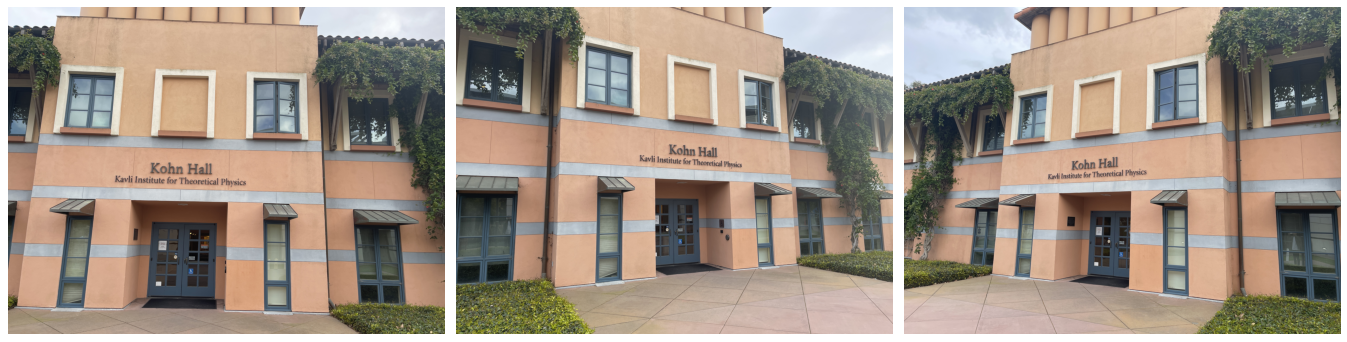

In [3]:
# We simply gather all the file paths and convert them into a form that is easier to handle
references = [p.relative_to(images).as_posix() for p in images.iterdir()]
print(len(references), "mapping images")

# `plot_images` is just for visualization, to ensure we are using the correct images
plot_images([read_image(images / r) for r in references], dpi=75)

In [8]:
extract_features.main(
    feature_conf, images, image_list=references, feature_path=features
)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2025/04/25 15:50:31 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}


  0%|          | 0/3 [00:00<?, ?it/s]

[2025/04/25 15:50:32 hloc INFO] Finished exporting features.
[2025/04/25 15:50:32 hloc INFO] Found 3 pairs.
[2025/04/25 15:50:32 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
/data/hardik/anaconda3/envs/3dReconstruction/lib/python3.12/site-packages/lightglue/lightglue.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


  0%|          | 0/3 [00:00<?, ?it/s]

[2025/04/25 15:50:34 hloc INFO] Finished exporting matches.


In [ ]:
import h5py
features_data = {}
matches_data = {}
with h5py.File(matches, "r") as f:
    print("Keys in the .h5 file:", list(f.keys()))
    for k in f.keys():
        matches_data[k] = {}
        for j in f[k].keys():
            matches_data[k][j] = {}
            for i in f[k][j].keys():
                matches_data[k][j][i] = f[k][j][i][:]
                
            
with h5py.File(features, "r") as f:
    print("Keys in the .h5 file:", list(f.keys()))
    for k in f.keys():
        features_data[k] = {}
        for j in f[k].keys():
            features_data[k][j] = f[k][j][:]
    

Keys in the .h5 file: ['IMG_1224.JPG', 'IMG_1226.JPG']
Matches data keys: (5000,)
Keys in the .h5 file: ['IMG_1223.JPG', 'IMG_1224.JPG', 'IMG_1226.JPG']


In [19]:
features_data["IMG_1224.JPG"]["keypoints"].shape, features_data["IMG_1224.JPG"]["descriptors"].shape

((5000, 2), (128, 5000))

In [28]:
matches_data["IMG_1224.JPG"]["IMG_1223.JPG"]["matches0"].shape, matches_data["IMG_1224.JPG"]["IMG_1223.JPG"]["matching_scores0"].shape

((5000,), (5000,))

In [31]:
print(matches_data["IMG_1224.JPG"]["IMG_1223.JPG"]["matches0"][:10])
print(matches_data["IMG_1224.JPG"]["IMG_1223.JPG"]["matching_scores0"][:10])


[ -1 849 953  -1  -1  -1  -1 947  -1 932]
[0.     0.8916 0.965  0.     0.     0.     0.     0.9517 0.     0.968 ]


In [34]:
import matplotlib.pyplot as plt

def plot_corresponding_points(img1_name, img2_name,top_k=15):
    # Load images
    img1 = read_image(images / img1_name)
    img2 = read_image(images / img2_name)
    
    # Get keypoints and matches
    keypoints1 = features_data[img1_name]["keypoints"]
    keypoints2 = features_data[img2_name]["keypoints"]
    matches = matches_data[img1_name][img2_name]["matches0"]
    scores = matches_data[img1_name][img2_name]["matching_scores0"]
    
    # Filter valid matches
    valid = matches != -1
    matched_keypoints1 = keypoints1[valid]
    matched_keypoints2 = keypoints2[matches[valid]]
    confidence_scores = scores[valid]

    # Sort by confidence scores and take top_k matches
    sorted_indices = np.argsort(confidence_scores)[::-1][:top_k]
    matched_keypoints1 = matched_keypoints1[sorted_indices]
    matched_keypoints2 = matched_keypoints2[sorted_indices]
    confidence_scores = confidence_scores[sorted_indices]
    # Normalize confidence scores for better visualization
    confidence_scores = (confidence_scores - confidence_scores.min()) / (confidence_scores.max() - confidence_scores.min())
    confidence_scores = confidence_scores * 100  # Scale to 0-100 for better visibility
    confidence_scores = confidence_scores.astype(int)
    
    # Plot images side by side
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(img1)
    ax[0].scatter(matched_keypoints1[:, 0], matched_keypoints1[:, 1], c=confidence_scores, cmap='viridis', s=10)
    ax[0].set_title(f"Keypoints in {img1_name}")
    
    ax[1].imshow(img2)
    ax[1].scatter(matched_keypoints2[:, 0], matched_keypoints2[:, 1], c=confidence_scores, cmap='viridis', s=10)
    ax[1].set_title(f"Keypoints in {img2_name}")
    
    plt.show()



In [41]:
import cv2

def overlay_images(img1_name, img2_name, top_k=15):
    # Load images
    img1 = read_image(images / img1_name)
    img2 = read_image(images / img2_name)
    
    # Get keypoints and matches
    keypoints1 = features_data[img1_name]["keypoints"]
    keypoints2 = features_data[img2_name]["keypoints"]
    matches = matches_data[img1_name][img2_name]["matches0"]
    scores = matches_data[img1_name][img2_name]["matching_scores0"]
    
    # Filter valid matches
    valid = matches != -1
    matched_keypoints1 = keypoints1[valid]
    matched_keypoints2 = keypoints2[matches[valid]]
    confidence_scores = scores[valid]

    # Sort by confidence scores and take top_k matches
    sorted_indices = np.argsort(confidence_scores)[::-1][:top_k]
    matched_keypoints1 = matched_keypoints1[sorted_indices]
    matched_keypoints2 = matched_keypoints2[sorted_indices]
    
    # Compute homography
    H, _ = cv2.findHomography(matched_keypoints1, matched_keypoints2, cv2.RANSAC)
    print(f"Homography matrix {img1_name} - {img2_name}: \n", H)
    
    # Warp img1 to align with img2
    height, width, _ = img2.shape
    warped_img1 = cv2.warpPerspective(img1, H, (width, height))
    
    # Overlay images
    overlay = cv2.addWeighted(warped_img1, 0.5, img2, 0.5, 0)
    
    # Display the result
    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Overlay of {img1_name} on {img2_name}")
    plt.axis("off")
    plt.show()



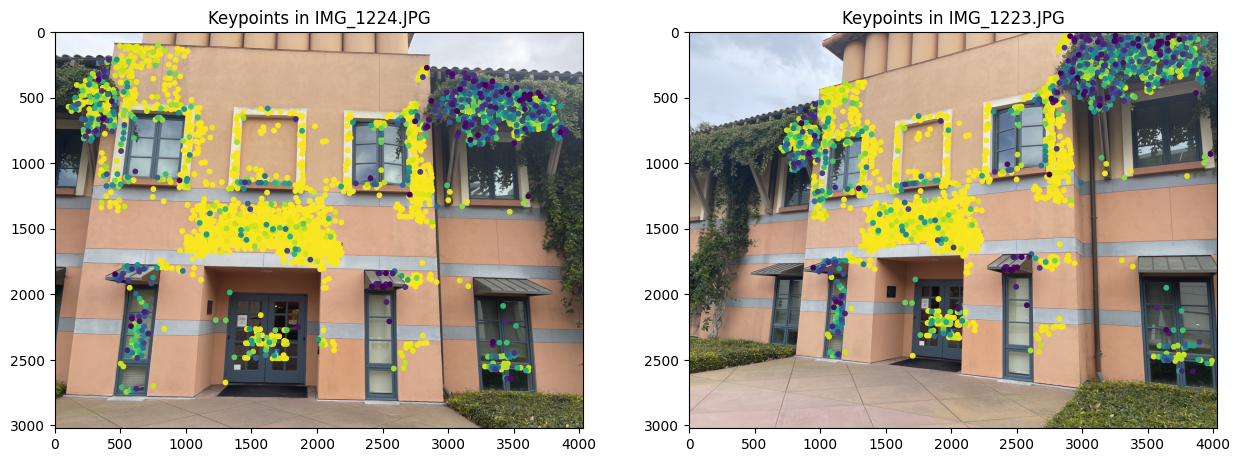

In [35]:
# Corresponding points: "IMG_1224.JPG" and "IMG_1223.JPG"
plot_corresponding_points("IMG_1224.JPG", "IMG_1223.JPG", 5000)

##### Here the colors of the matched points follow cmap='viridis' based on their confidence scores

/tmp/ipykernel_3858514/2045766811.py:26: RuntimeWarning: invalid value encountered in divide
  confidence_scores = (confidence_scores - confidence_scores.min()) / (confidence_scores.max() - confidence_scores.min())
/tmp/ipykernel_3858514/2045766811.py:28: RuntimeWarning: invalid value encountered in cast
  confidence_scores = confidence_scores.astype(int)


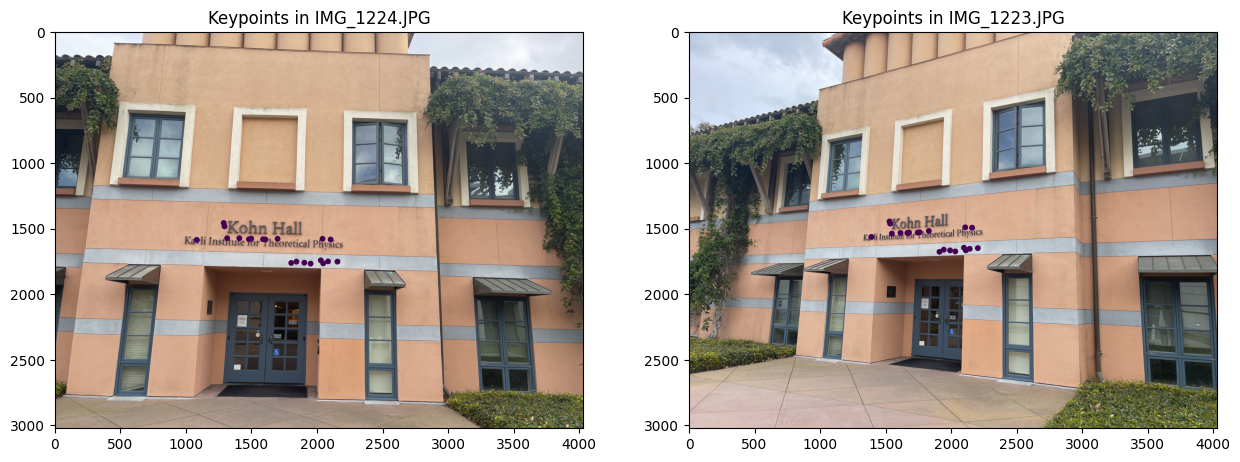

In [36]:
plot_corresponding_points("IMG_1224.JPG", "IMG_1223.JPG", 20)

Homography matrix IMG_1224.JPG - IMG_1223.JPG: 
 [[ 4.34882959e-01  3.05150181e-02  7.39119321e+02]
 [-2.31809793e-01  7.77098464e-01  4.31745194e+02]
 [-1.13955116e-04  1.72314346e-05  1.00000000e+00]]


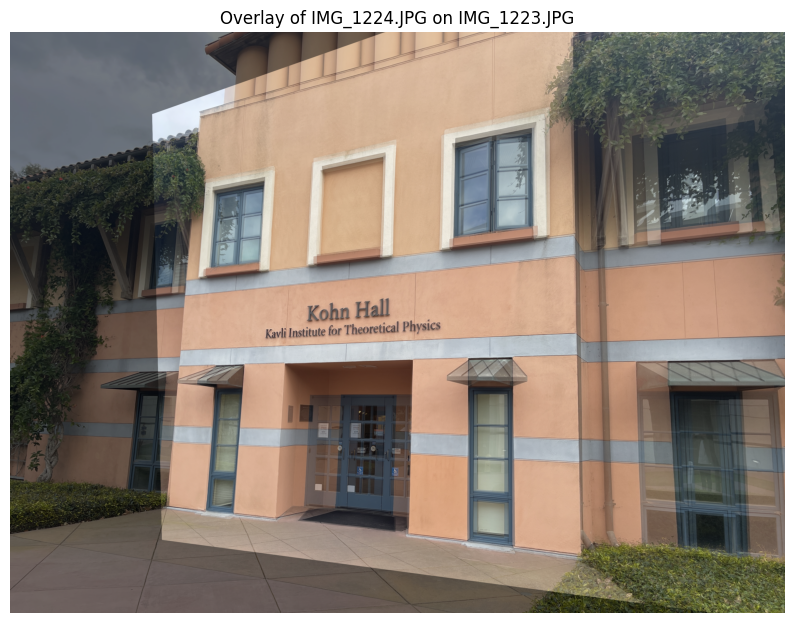

In [43]:
# Example usage
overlay_images("IMG_1224.JPG", "IMG_1223.JPG", top_k=20)

#### The alignment looks super solid. There are a few artifacts, especially when the depth of a surface varies a lot.

In [63]:
def compute_fundamental_matrix_and_draw_epilines(img1_name, img2_name, top_k=15, N_epipolarLines=20):
    # Load images
    img1 = read_image(images / img1_name)
    img2 = read_image(images / img2_name)
    
    # Get keypoints and matches
    keypoints1 = features_data[img1_name]["keypoints"]
    keypoints2 = features_data[img2_name]["keypoints"]
    matches = matches_data[img1_name][img2_name]["matches0"]
    scores = matches_data[img1_name][img2_name]["matching_scores0"]
    
    # Filter valid matches
    valid = matches != -1
    matched_keypoints1 = keypoints1[valid]
    matched_keypoints2 = keypoints2[matches[valid]]
    confidence_scores = scores[valid]

    # Sort by confidence scores and take top_k matches
    sorted_indices = np.argsort(confidence_scores)[::-1]
    matched_keypoints1 = matched_keypoints1[sorted_indices]
    matched_keypoints2 = matched_keypoints2[sorted_indices]
    
    # Sort by confidence scores and take top_k matches
    
    matched_keypoints1_topK = matched_keypoints1[:top_k]
    matched_keypoints2_topK = matched_keypoints2[:top_k]
    
    # Compute Fundamental matrix
    F, mask = cv2.findFundamentalMat(matched_keypoints1_topK, matched_keypoints2_topK, cv2.FM_RANSAC)
    print(f"Fundamental matrix {img1_name} - {img2_name}: \n", F)
    
    # Select N=20 random keypoints from the ones not used in the fundamental matrix computation
    # Define the exclusion list
    exclude = sorted_indices[:top_k]

    # Create the list of allowed values
    allowed_values = np.setdiff1d(np.arange(0, len(matched_keypoints1)), exclude)

    # Shuffle and select without replacement
    selected = np.random.choice(allowed_values, size=N_epipolarLines, replace=False)

    # Get the selected keypoints
    inlier_keypoints1 = matched_keypoints1[selected]
    inlier_keypoints2 = matched_keypoints2[selected]
        
    # Compute epilines for points in the first image and draw them on the second image
    epilines = cv2.computeCorrespondEpilines(inlier_keypoints1.reshape(-1, 1, 2).astype(np.float32), 1, F)
    epilines = epilines.reshape(-1, 3)
    
    img1_with_keypoints = img1.copy()
    img2_with_lines = img2.copy()
    for r, pt1, pt2 in zip(epilines, inlier_keypoints1, inlier_keypoints2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [img2.shape[1], -(r[2] + r[0] * img2.shape[1]) / r[1]])
        img2_with_lines = cv2.line(img2_with_lines, (x0, y0), (x1, y1), color, 3)
        img2_with_lines = cv2.circle(img2_with_lines, tuple(pt2.astype(int)), 10, color, 10)
        img1_with_keypoints = cv2.circle(img1_with_keypoints, tuple(pt1.astype(int)), 10, color, 10)
    
    # Display the results
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax[0].imshow(img1_with_keypoints)
    ax[0].set_title(f"Keypoints in {img1_name}")
    ax[0].axis("off")
    
    ax[1].imshow(img2_with_lines)
    ax[1].set_title(f"Epipolar lines on {img2_name}")
    ax[1].axis("off")
    
    plt.show()
    
    return F

Fundamental matrix IMG_1224.JPG - IMG_1223.JPG: 
 [[ 4.94399006e-09  9.36451095e-07 -2.02232902e-03]
 [-7.88974075e-07  9.17983352e-09  1.29202918e-03]
 [ 1.59887258e-03 -1.70092708e-03  1.00000000e+00]]


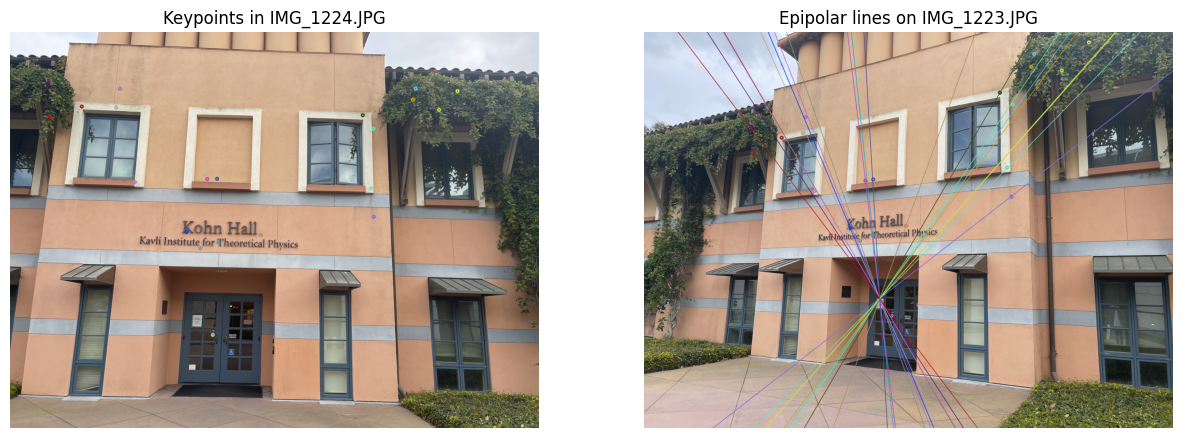

In [64]:
F_1224to1223 = compute_fundamental_matrix_and_draw_epilines("IMG_1224.JPG", "IMG_1223.JPG", top_k=20, N_epipolarLines=20)

Fundamental matrix IMG_1226.JPG - IMG_1223.JPG: 
 [[ 2.22520158e-07 -1.22654350e-06  1.01427628e-03]
 [ 1.10716319e-06 -1.64160122e-07 -1.86402961e-03]
 [-1.81800047e-03  2.04048811e-03  1.00000000e+00]]


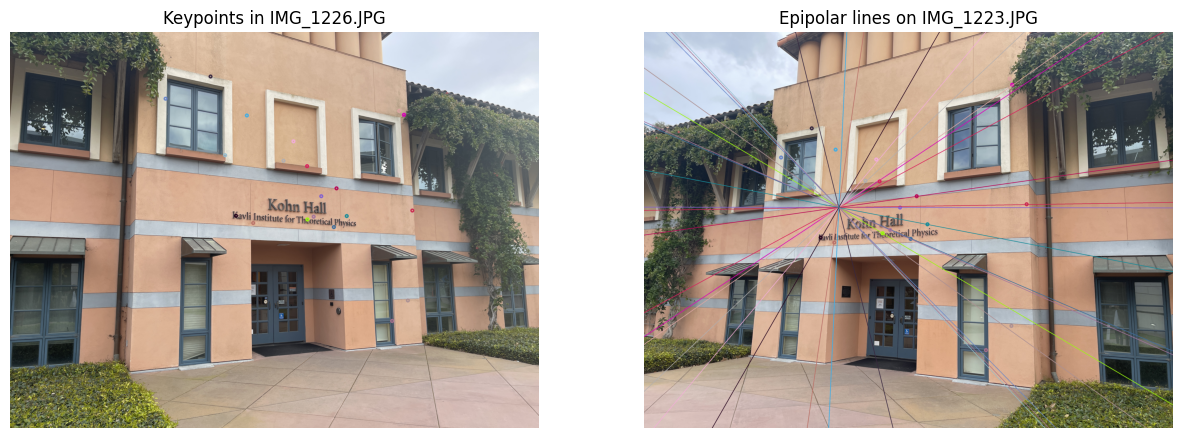

In [65]:
F_1226to1223 = compute_fundamental_matrix_and_draw_epilines("IMG_1226.JPG", "IMG_1223.JPG", top_k=20, N_epipolarLines=20)

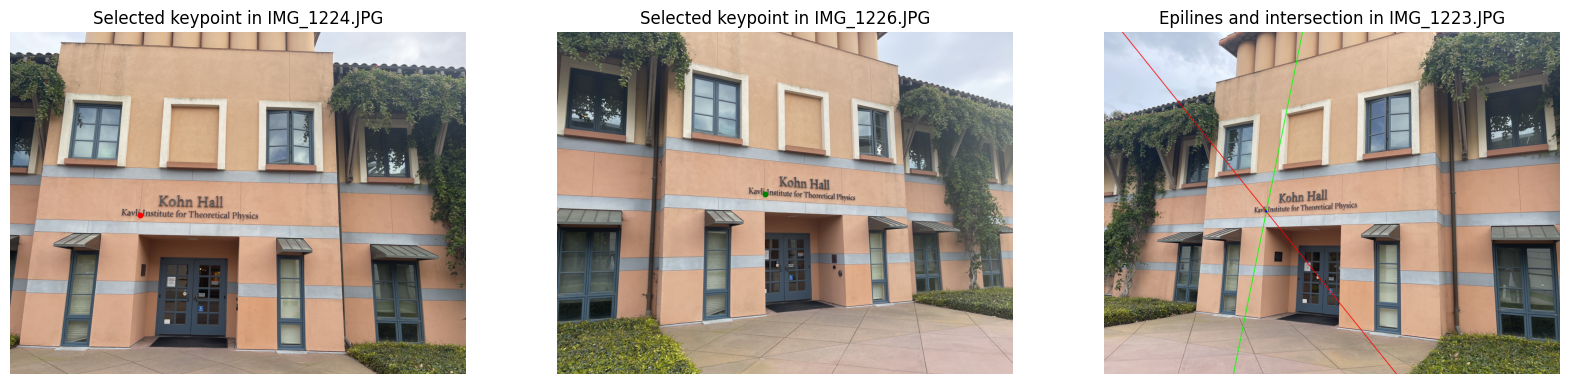

In [73]:
def find_intersection_and_draw_epilines(img1_name, img2_name, img3_name, F1, F2):
    # Load images
    img1 = read_image(images / img1_name)
    img2 = read_image(images / img2_name)
    img3 = read_image(images / img3_name)
    
    # Get keypoints and matches
    keypoints1 = features_data[img1_name]["keypoints"]
    keypoints2 = features_data[img2_name]["keypoints"]
    matches = matches_data[img1_name][img2_name]["matches0"]
    scores = matches_data[img1_name][img2_name]["matching_scores0"]
    
    # Filter valid matches
    valid = matches != -1
    matched_keypoints1 = keypoints1[valid]
    matched_keypoints2 = keypoints2[matches[valid]]
    confidence_scores = scores[valid]

    # Sort by confidence scores and take top_k matches
    sorted_indices = np.argsort(confidence_scores)[::-1]
    matched_keypoints1 = matched_keypoints1[sorted_indices]
    matched_keypoints2 = matched_keypoints2[sorted_indices]
    
    # Select a keypoint from img1 and img2
    keypoint_index = np.random.randint(0, len(matched_keypoints1)//2)
    selected_keypoint1 = matched_keypoints1[keypoint_index]
    selected_keypoint2 = matched_keypoints2[keypoint_index]
    
    # Compute epilines for the selected keypoints in img3
    epiline1 = cv2.computeCorrespondEpilines(selected_keypoint1.reshape(-1, 1, 2).astype(np.float32), 1, F1).reshape(-1, 3)
    epiline2 = cv2.computeCorrespondEpilines(selected_keypoint2.reshape(-1, 1, 2).astype(np.float32), 1, F2).reshape(-1, 3)
    
    # Find the intersection point of the two epilines
    a1, b1, c1 = epiline1[0]
    a2, b2, c2 = epiline2[0]
    A = np.array([[a1, b1], [a2, b2]])
    B = np.array([-c1, -c2])
    intersection_point = np.linalg.solve(A, B)
    
    # Draw the epilines on img3
    img3_with_lines = img3.copy()
    x0, y0 = map(int, [0, -c1 / b1])
    x1, y1 = map(int, [img3.shape[1], -(c1 + a1 * img3.shape[1]) / b1])
    img3_with_lines = cv2.line(img3_with_lines, (x0, y0), (x1, y1), (255, 0, 0), 5)
    
    x0, y0 = map(int, [0, -c2 / b2])
    x1, y1 = map(int, [img3.shape[1], -(c2 + a2 * img3.shape[1]) / b2])
    img3_with_lines = cv2.line(img3_with_lines, (x0, y0), (x1, y1), (0, 255, 0), 5)
    
    # Mark the intersection point
    img3_with_lines = cv2.circle(img3_with_lines, tuple(intersection_point.astype(int)), 10, (0, 0, 255), -1)
    
    # Display the images
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    ax[0].imshow(img1)
    ax[0].scatter(selected_keypoint1[0], selected_keypoint1[1], c='red', s=10)
    ax[0].set_title(f"Selected keypoint in {img1_name}")
    ax[0].axis("off")
    
    ax[1].imshow(img2)
    ax[1].scatter(selected_keypoint2[0], selected_keypoint2[1], c='green', s=10)
    ax[1].set_title(f"Selected keypoint in {img2_name}")
    ax[1].axis("off")
    
    ax[2].imshow(img3_with_lines)
    ax[2].set_title(f"Epilines and intersection in {img3_name}")
    ax[2].axis("off")
    
    plt.show()

# Example usage
find_intersection_and_draw_epilines("IMG_1224.JPG", "IMG_1226.JPG", "IMG_1223.JPG", F_1224to1223, F_1226to1223)